## Assignment 2
In this assignment, I was given a binomial model for a stock and three actions: short 1 stock, short 0.5 stock, short 0 stock. I was required to use Q learning to compute the optimal policy for the the stock.

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

Firstly, I create a class named stock_price to generate binomial model for the stock prices.

In [2]:
class stock_price():
    def __init__(self, n, T, volatility, r, initial_price):
        self.n = n
        deltaT = T/n
        self.u = np.exp(volatility*np.sqrt(deltaT))
        self.d = 1/self.u
        self.p = (np.exp(r*deltaT) - self.d)/(self.u - self.d)
        self.discount = np.exp(-r*deltaT)
        self.price = dict()
        self.price[(1, 0)] = [initial_price, self.u*initial_price, self.d*initial_price]
        self.initial_price = initial_price

    # Here we generate the stock prices following the n-depth binomial model   
    def generate_stock_price(self):
        for i in range(2, self.n + 1):
            for j in range(i):
                temp_value = pow(self.u, i - 1 - j)*pow(self.d, j)*self.initial_price
                temp_u = temp_value*self.u
                temp_d = temp_value*self.d
                self.price[(i, j)] = [temp_value, temp_u, temp_d]

Q-Learning is an Off-Policy algorithm for Temporal Difference learning. I use $\epsilon$-greedy policy for the Q-Learning.

In [6]:
class Q_learning_agent():
    def __init__(self, epsilon, alpha, StockPrice, actions):
        self.epsilon = epsilon
        self.alpha = alpha
        self.q_table = np.zeros(int(StockPrice.n*(StockPrice.n+1)/2)*3)
        self.StockPrice = StockPrice
        self.actions = actions
        
    # Calculate the reward we got from a state transfering to the next state given the action we choose
    def get_reward(self, state, next_state, action):
        reward = 0
        state = tuple(state)
        next_state = tuple(next_state)
        # We set the reward to be the money we lost
        if self.StockPrice.price[next_state][0] < self.StockPrice.price[state][0]:
            reward = (self.StockPrice.price[next_state][0] - self.StockPrice.price[state][0])*self.StockPrice.discount*(1 + action)
        return reward
    
    # hash state (i, j) into one positive integer number
    def state_hash(self, state):
        return int(state[0]*(state[0]-1)/2) + state[1]
    
    # hash state (i, j) and action into one positive integer number
    def state_action_hash(self, state, action):
        return self.state_hash(state)*3 + self.actions.index(action)
    
    def policy(self, state):
        # Choose action according to the epsilon-greedy policy
        temp_epsilon = random.random()
        if temp_epsilon < self.epsilon:
            action = random.choice(self.actions)
        else:
            temp_q_value = [self.q_table[self.state_action_hash(state, k)] for k in self.actions]
            action = self.actions[np.argmax(np.array(temp_q_value))]
        return action
    
    def episode_train(self):
        state = [1, 0]
        while True:
            action = self.policy(state)
            # Update the q table
            if state[0] < self.StockPrice.n:
                # Choose next state according to the Stock price model
                temp_p = random.random()
                if temp_p < self.StockPrice.p:
                    next_state = [state[0] + 1, state[1]]
                else:
                    next_state = [state[0] + 1, state[1] + 1]
                temp_state_hash = self.state_action_hash(state, action)
                reward = self.get_reward(state, next_state, action)
                next_state_hash = self.state_action_hash(next_state, action)
                next_state_q_value = [self.q_table[self.state_action_hash(next_state, k)] for k in self.actions]
                self.q_table[temp_state_hash] += self.alpha*(reward + self.StockPrice.discount*max(next_state_q_value) - self.q_table[temp_state_hash])
                state = next_state
            else:
                temp_p = random.random()
                reward = 0
                if temp_p >= self.StockPrice.p:
                    state_ = tuple(state)
                    reward = (self.StockPrice.price[state_][2] - self.StockPrice.price[state_][0])*self.StockPrice.discount*(1 + action)
                temp_state_hash = self.state_action_hash(state, action)
                self.q_table[temp_state_hash] += self.alpha*(reward - self.q_table[temp_state_hash])
                break
    
    def Train(self, m, target_policy):
        distance_to_target_policy = []
        for i in range(m):
            self.episode_train()
            current_optimal_value, current_optimal_policy = self.find_optimal_value()
            distance_to_target_policy.append(np.sum(np.abs(current_optimal_policy - target_policy)))
        distance = pd.DataFrame({'distance_to_target_policy':distance_to_target_policy})
        return distance
        
    def find_optimal_value(self):
        optimal_state_value = np.zeros(int(self.StockPrice.n*(self.StockPrice.n+1)/2))
        optimal_policy = np.zeros(int(self.StockPrice.n*(self.StockPrice.n+1)/2))
        for i in range(1, self.StockPrice.n + 1):
            for j in range(i):
                state = (i, j)
                temp_action_value = []
                for action in self.actions:
                    temp_state_action_hash = self.state_action_hash(state, action)
                    temp_action_value.append(self.q_table[temp_state_action_hash])
                optimal_state_value[self.state_hash(state)] = max(temp_action_value)
                optimal_policy[self.state_hash(state)] = self.actions[temp_action_value.index(max(temp_action_value))]
        return optimal_state_value, optimal_policy
  

In [13]:
def Q_Learning():
    actions = [0, -0.5, -1]
    n = 10
    T = 1
    volatility = 0.1
    r = 0.02
    initial_price = 100
    stockprice = stock_price(n, T, volatility, r, initial_price)
    stockprice.generate_stock_price()
    epsilon = 0.1
    alpha = 0.7
    target_policy = -np.ones(int(n*(n+1)/2))
    q_learning = Q_learning_agent(epsilon, alpha, stockprice, actions)
    distance = q_learning.Train(5000, target_policy)
    distance.plot(title = 'Distance to Target Policy for Q Learning')
    plt.show()
    optimal_state_value, optimal_policy = q_learning.find_optimal_value()
    print('optimal_state_value:')
    print(optimal_state_value)
    print('optimal_policy:')
    print(optimal_policy)

<IPython.core.display.Javascript object>


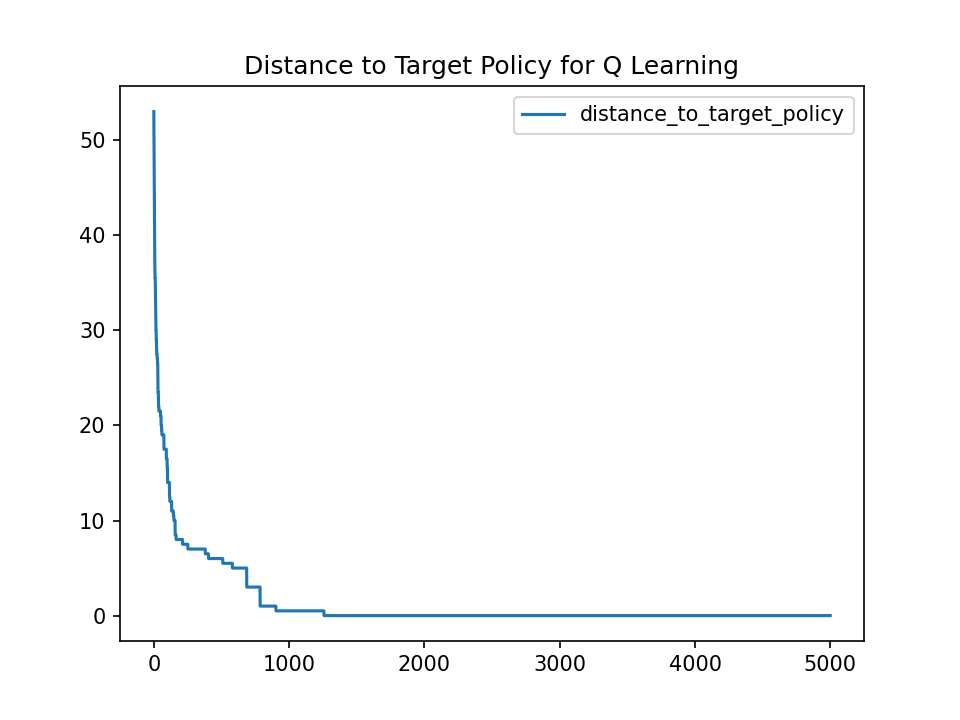

optimal_state_value:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
optimal_policy:
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.]


In [14]:
Q_Learning()

In [39]:
def optimal_epsilon():
    actions = [0, -0.5, -1]
    n = 10
    T = 1
    volatility = 0.1
    r = 0.02
    initial_price = 100
    stockprice = stock_price(n, T, volatility, r, initial_price)
    stockprice.generate_stock_price()
    alpha = 1
    epsilon = [0.1, 0.3, 0.5, 0.7]
    Distance = pd.DataFrame()
    training_time = 20
    for i in range(len(epsilon)):
        distance = pd.DataFrame()
        for j in range(training_time):
            target_policy = -np.ones(int(n*(n+1)/2))
            q_learning = Q_learning_agent(epsilon[i], alpha, stockprice, actions)
            distance_ = q_learning.Train(5000, target_policy)
            optimal_state_value, optimal_policy = q_learning.find_optimal_value()
            distance_.rename(columns = {'distance_to_target_policy':f'epsilon = {epsilon[i]}'}, inplace = True)
            if j == 0:
                distance = distance_
            else:
                distance += distance_
        distance = distance/training_time
        Distance = pd.concat([Distance, distance], axis = 1)
    Distance.plot(title = 'Distance to Target Policy for Q Learning with different Epsilon')
    plt.show()
    

<IPython.core.display.Javascript object>


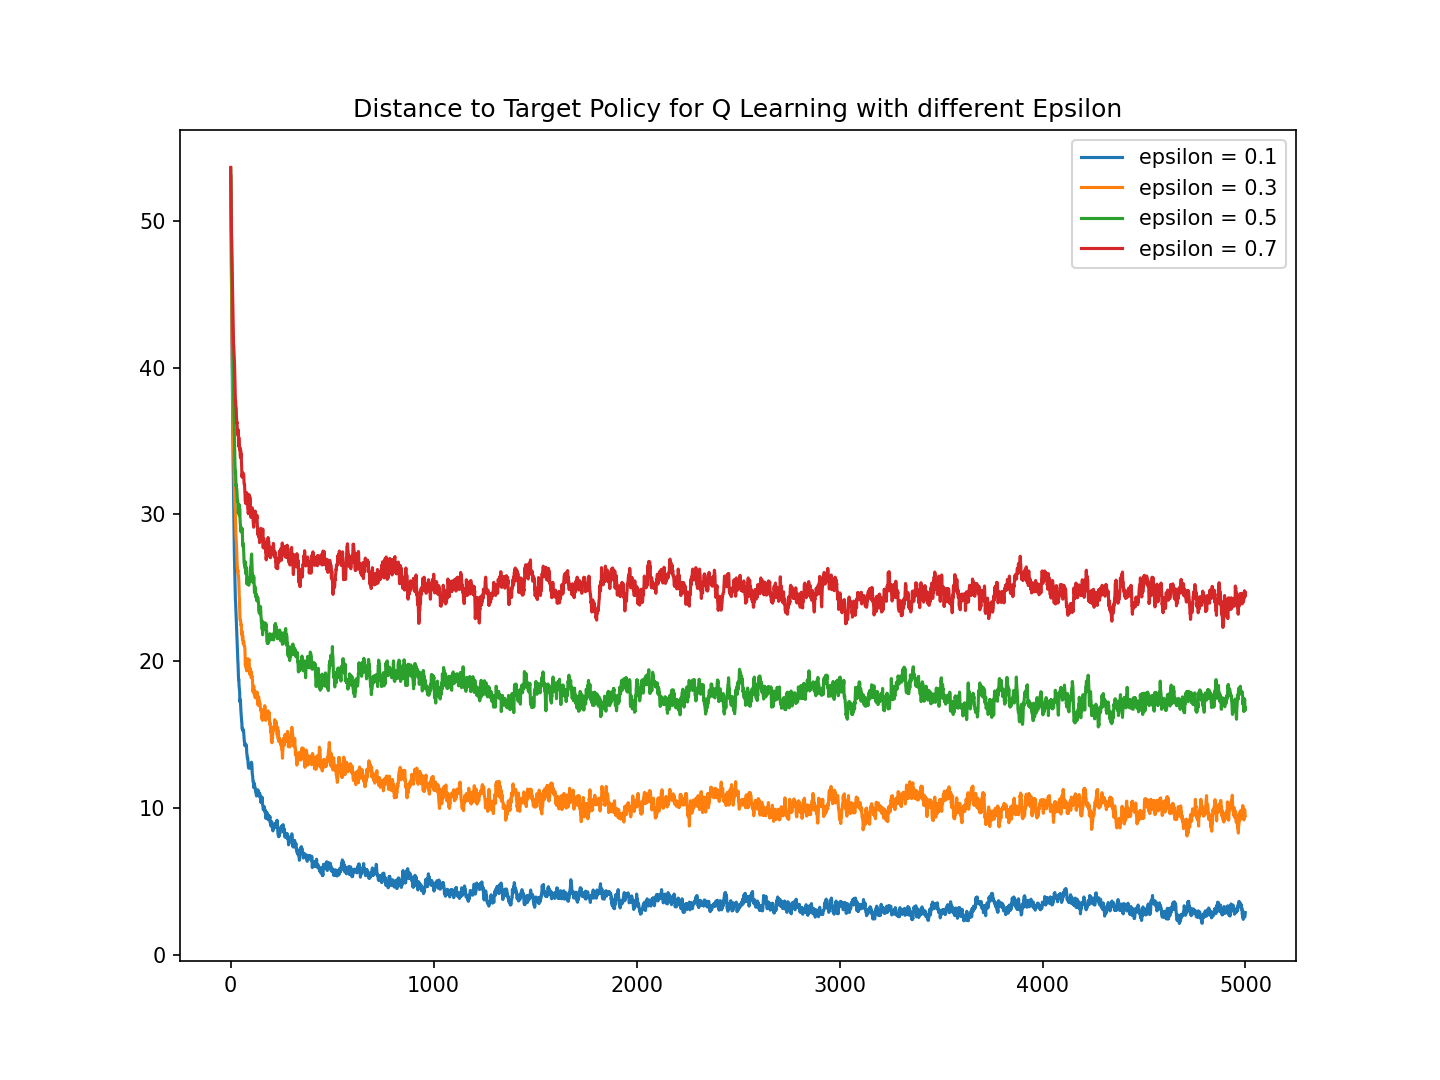

In [40]:
optimal_epsilon()